In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBRegressor
from pyGRNN import GRNN
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#3 lines written by me

In [3]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

#9 lines written by me

In [4]:
"""
Refactored from: 

https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285

"""

def shift_dataframe(data):
    #The value in "shift(-x)" is the lookback period in this case 1.
    data["Target"] = data.Val.shift(-1)
    data.dropna(inplace=True)
    
    return data

#4 lines taken from guide above

In [5]:
def mean_imputation(data):
    filled = data.fillna(data.mean())
    filled.drop(data.tail(1).index,inplace=True) #remove last row
    
    return filled

#3 lines written by me

In [6]:
"""
referenced from: https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b3
"""

def train_test_split(data):
    
    train = data[:int(len(data)*0.8)]
    test = data[int(len(data) * 0.8):]
    
    return train, test

In [7]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    
#15 Lines. 3 From documentation, 3 from github, 9 written by me

In [8]:
data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'SL.UEM.TOTL.MA.ZS')
filled = mean_imputation(data)
shifted = shift_dataframe(filled)

In [9]:
X = shifted.Val.values.reshape(-1,1)
y = shifted.Target.values

In [10]:
"""
IDEA FOR USING TSCV FROM: 

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

[Produces exactly the same output as WFV from the file 'Univariate Forecast Final XGBoost']
Code for TSCV from: 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
"""

tscv = TimeSeriesSplit(test_size=len(filled) - int(len(filled)*0.8), n_splits=4)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [11]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,
                    max_depth=6, learning_rate=0.3)
model.fit(X_train, y_train, verbose=False)
y_pred = model.predict(X_test)

In [12]:
dtest = data.fillna(data.mean())
dtest.drop(data.tail(1).index, inplace=True)
newindextest = dtest[int(len(data)*0.8):]
newindex = newindextest.index.values.tolist()

RMSE:  0.6765516311029096
MAPE:  11.561456016196162
MAE:  0.5494929353396106
Scatter Index:  14.300897554811694
MDA:  0.45454545454545453
Mean of actual:  4.73083335161209


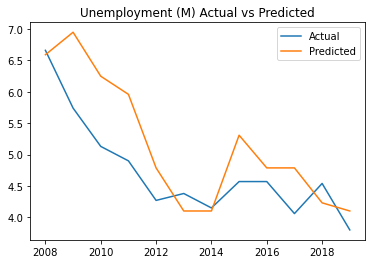

In [13]:
df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.index = newindex
df_compare.plot(title= 'Unemployment (M) Actual vs Predicted')
performance_metrics(y_test, y_pred)
#5 lines written by me

Text(0.5, 1.0, 'Learning Curve, XGB Unemployment (F)')

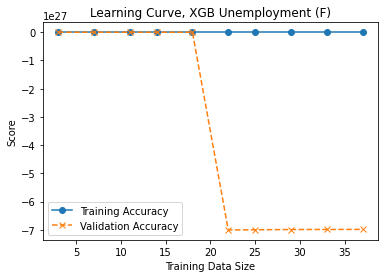

In [14]:
"""
Learning Curve to detect overfit/underfit

Method from: 

https://vitalflux.com/learning-curves-explained-python-sklearn-example/amp/
and
https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html#:~:text=Learning%20curves%20can%20be%20generated,see%20in%20the%20following%20examples.

"""

pipeline = make_pipeline(model)

train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train,
                                                      y=y_train, cv=5,
                                                      train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy')
plt.xlabel('Training Data Size')
plt.plot(train_sizes, test_mean, marker='x', linestyle='--', label='Validation Accuracy')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve, XGB Unemployment (F)')

#14 lines taken directly from guide, integrated with my model


In [15]:
train_mean

array([ 0.00000000e+00,  0.00000000e+00, -2.98255035e+17, -2.98255035e+17,
       -2.98255035e+17, -1.19302014e+17,  3.64569825e-01, -1.19302014e+17,
        7.60069013e-01,  8.25012445e-01])

In [16]:
test_mean

array([-4.69154057e+17, -1.19302014e+17, -1.19302014e+17, -1.19302014e+17,
       -1.19302014e+17, -7.00427471e+27, -6.99967188e+27, -6.98990299e+27,
       -6.98757536e+27, -6.98558867e+27])